In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.integrate as si
import matplotlib.pyplot as plt

In [33]:
# function we are trying to approximate
def f(x, choice=4):
    if choice == 0:
        # dimensionless quantum harmonic oscillator potential
        return 0.5 * x**2
    elif choice == 1:
        # symmetric double well potential
        return 0.0025 * (x ** 2 - 25) ** 2
    elif choice == 2:
        # asymmetric double well potential
        return 0.0003 * ((x - 3) ** 4 + 10 * (x - 5) ** 3)
    elif choice == 3:
        # soft coulomb potential
        return -1 / np.sqrt(x ** 2 + 0.25)
    elif choice == 4:
        # a complicated function made by Harish
        return np.cos(x**2) - x*np.sin(x)
    elif choice == 5:
        # a square potential well
        return -2 * np.logical_and(x >= -2, x <= 2)
    else:
        print('Function v(x, choice=0): Did not recognise your input for choice.')

In [3]:
# vectorized version of Gaussian basis function
# Gaussian centered at grid point j*h with shape parameter alpha
# z_{ij} = x_i - j*h
def gbm(z, alpha):
    return np.exp(-alpha * z**2)

In [4]:
def gbmatfn(x1, x2, alpha):
    # make arrays that can be used in vectorized evaluations
    # row values are x1 and column values are x2
    x1v, x2v = np.meshgrid(x1, x2, sparse=True, indexing='ij')

    # make Gaussian basis matrix
    # We want [gbmat @ cfs](x_i) = vtrue(x_i), so each row
    # in gbmat is an x_i point and each column is a j*h
    # point. Given N x_i points and J j values, gbmat
    # is an NxJ matrix
    return gbm(x1v - x2v, alpha)

In [5]:
# function for computing the Gaussian basis coefficients
def gbcfs(fn, J, L, alpha):
    # make vector of x points for Gaussian centers
    # with spacing h
    h = L/J
    xg = np.arange(-J, J+1) * h

    # make Gaussian basis matrix
    gbmat = gbmatfn(xg, xg, alpha)

    # vector of the function evaluated on
    # the xg grid (needed for computing
    # basis coefficients)
    fxgt = fn(xg)

    # solve gbmat @ gbcfs = fxjtrue
    # to compute Gaussian basis coefficients
    # gbmat must be a square matrix
    cfs = sl.solve(gbmat, fxgt, assume_a='sym')

    return cfs, xg

In [6]:
def L2err(cfs, fn, xg, L, alpha):
    # function representation of L2 norm
    def integrand(x):
        # when more than one x point is evaluated,
        # x forms the rows and xg forms the columns
        gbmat = gbmatfn(x, xg, alpha)
        return np.square(gbmat @ cfs - fn(x))

    # integrate to get the square of the L2 error
    l2errsq, _ = si.quadrature(integrand, -L, L, maxiter=500, tol=1e-8, rtol=1e-8)
    return np.sqrt(l2errsq)

In [7]:
# compute L^\infty error

# Grid of x_i points should be fine enough that the answer is stable
# (i.e. further refinement does not appreciably change the answer)
# also the answer should be reasonably accurate, that is, if
# you graph |fapprox(x) - f(x)| vs. x that the maximum isn't
# obviously different from the L^\infty error

def Linferr(n, cfs, fn, xg, L, alpha):
    x = np.linspace(-L, L, n)
    fxt = fn(x)
    gbmat = gbmatfn(x, xg, alpha)
    fxp = gbmat @ cfs
    absdif = np.abs(fxp - fxt)
    return np.max(absdif)

/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=1.4513e-19): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')


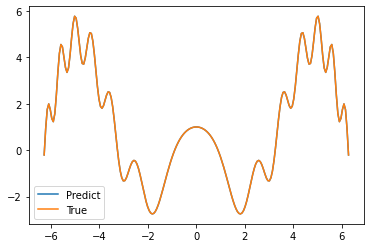

h value: 0.06283185307179587
L2 Error: 1.0412456291623661e-07
L\infty Error: 4.008228400853575e-07


In [34]:
bigJ = 100
bigL = 2*np.pi
myalpha = 6.0
cfsrtn, xgrtn = gbcfs(f, bigJ, bigL, myalpha)

gbmatrtn = gbmatfn(xgrtn, xgrtn, myalpha)

fxtrue = f(xgrtn)
fxprdt = gbmatrtn @ cfsrtn

# plot the truth vs reconstruction
plt.plot(xgrtn, fxprdt, label='Predict')
plt.plot(xgrtn, fxtrue, label='True')
plt.legend()
plt.show()

print(f'h value: {bigL/bigJ}',
      f'L2 Error: {L2err(cfsrtn, f, xgrtn, bigL, myalpha)}',
      f'L\infty Error: {Linferr(1000, cfsrtn, f, xgrtn, bigL, myalpha)}',
      sep='\n')

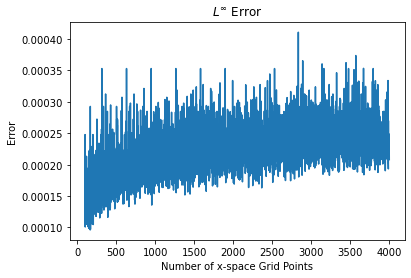

In [9]:
nvec = range(100, 4000)
lennvec = len(nvec)
Linferrvec = np.zeros(lennvec, dtype=float)
for i in range(lennvec):
    Linferrvec[i] = Linferr(nvec[i], cfsrtn, f, xgrtn, bigL, myalpha)

plt.plot(nvec, Linferrvec)
plt.title(r'$L^\infty$ Error')
plt.xlabel('Number of x-space Grid Points')
plt.ylabel('Error')
plt.show()

---

In [35]:
jspace = np.arange(5, 120+1)  # 60)
lenjspace = len(jspace)
hvec = np.zeros(lenjspace, dtype=float)
L2errvec = np.zeros(lenjspace, dtype=float)
LIerrvec = np.zeros(lenjspace, dtype=float)

# main loop
for i in range(lenjspace):
    print(f'Computing {i+1} of {lenjspace}')
    hvec[i] = bigL / jspace[i]
    thiscfs, thisxgr = gbcfs(f, jspace[i], bigL, myalpha)
    L2errvec[i] = L2err(thiscfs, f, thisxgr, bigL, myalpha)
    LIerrvec[i] = Linferr(2000, thiscfs, f, thisxgr, bigL, myalpha)

Computing 1 of 116
Computing 2 of 116
Computing 3 of 116
Computing 4 of 116
Computing 5 of 116
Computing 6 of 116
Computing 7 of 116
Computing 8 of 116
Computing 9 of 116
Computing 10 of 116
Computing 11 of 116
Computing 12 of 116
Computing 13 of 116
Computing 14 of 116
Computing 15 of 116
Computing 16 of 116
Computing 17 of 116
Computing 18 of 116
Computing 19 of 116
Computing 20 of 116
Computing 21 of 116
Computing 22 of 116
Computing 23 of 116
Computing 24 of 116
Computing 25 of 116
Computing 26 of 116
Computing 27 of 116
Computing 28 of 116
Computing 29 of 116
Computing 30 of 116
Computing 31 of 116
Computing 32 of 116
Computing 33 of 116
Computing 34 of 116
Computing 35 of 116
Computing 36 of 116
Computing 37 of 116
Computing 38 of 116
Computing 39 of 116
Computing 40 of 116
Computing 41 of 116
Computing 42 of 116
Computing 43 of 116
Computing 44 of 116
Computing 45 of 116
Computing 46 of 116
Computing 47 of 116
Computing 48 of 116
Computing 49 of 116
Computing 50 of 116
Computing

/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=3.02764e-17): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=4.69255e-18): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=1.94871e-18): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=6.8385e-18): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=6.16548e-19): resul

Computing 98 of 116
Computing 99 of 116
Computing 100 of 116
Computing 101 of 116
Computing 102 of 116
Computing 103 of 116
Computing 104 of 116
Computing 105 of 116
Computing 106 of 116
Computing 107 of 116
Computing 108 of 116
Computing 109 of 116
Computing 110 of 116
Computing 111 of 116
Computing 112 of 116
Computing 113 of 116
Computing 114 of 116
Computing 115 of 116
Computing 116 of 116


/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=2.00174e-19): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=1.6796e-19): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=1.56052e-19): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=6.55708e-20): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=3.29429e-20): resul

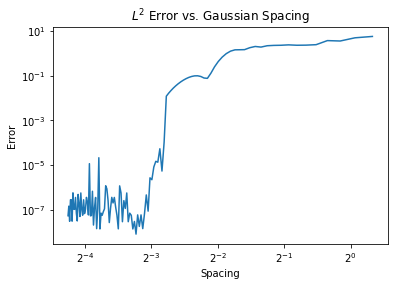

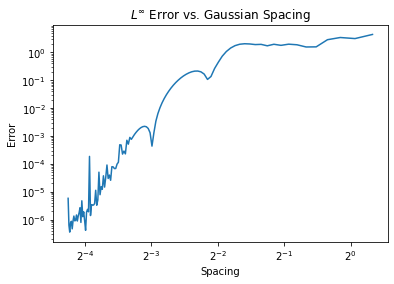

In [36]:
plt.loglog(hvec, L2errvec)
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.title(r'$L^2$ Error vs. Gaussian Spacing')
plt.xlabel('Spacing')
plt.ylabel('Error')
plt.show()

plt.loglog(hvec, LIerrvec)
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.title(r'$L^\infty$ Error vs. Gaussian Spacing')
plt.xlabel('Spacing')
plt.ylabel('Error')
plt.show()

---

/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=3.90918e-17): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=1.9857e-18): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=1.41997e-18): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=1.04045e-18): result may not be accurate.
  cfs = sl.solve(gbmat, fxgt, assume_a='sym')
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_6040/246870741.py:19: LinAlgWarning: Ill-conditioned matrix (rcond=8.63416e-20): resul

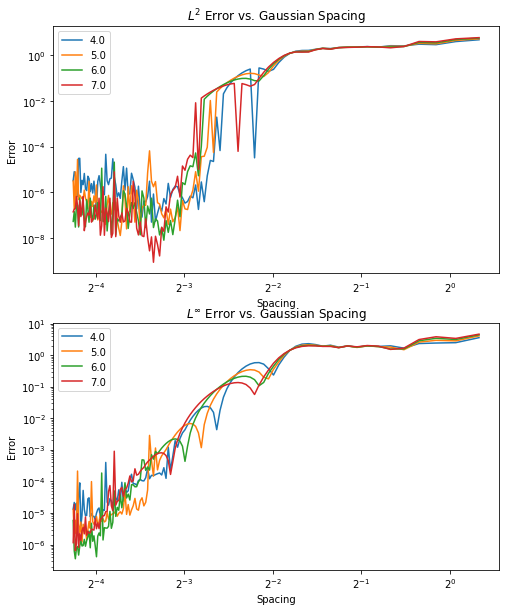

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

for thisalpha in np.arange(4, 8, dtype=float):
    jspace = np.arange(5, 120+1)  # 60)
    lenjspace = len(jspace)
    hvec = np.zeros(lenjspace, dtype=float)
    L2errvec = np.zeros(lenjspace, dtype=float)
    LIerrvec = np.zeros(lenjspace, dtype=float)

    # main loop
    for i in range(lenjspace):
        # print(f'Computing {i+1} of {lenjspace}')
        hvec[i] = bigL / jspace[i]
        thiscfs, thisxgr = gbcfs(f, jspace[i], bigL, thisalpha)
        L2errvec[i] = L2err(thiscfs, f, thisxgr, bigL, thisalpha)
        LIerrvec[i] = Linferr(2000, thiscfs, f, thisxgr, bigL, thisalpha)

    ax1.loglog(hvec, L2errvec, label=f'{thisalpha}')
    ax2.loglog(hvec, LIerrvec, label=f'{thisalpha}')


ax1.set_title(r'$L^2$ Error vs. Gaussian Spacing')
ax1.set_xscale('log', base=2)
ax1.set_yscale('log', base=10)
ax1.set_xlabel('Spacing')
ax1.set_ylabel('Error')
ax1.legend()

ax2.set_title(r'$L^\infty$ Error vs. Gaussian Spacing')
ax2.set_xscale('log', base=2)
ax2.set_yscale('log', base=10)
ax2.set_xlabel('Spacing')
ax2.set_ylabel('Error')
ax2.legend()

plt.show()